# House Prices: Advanced Regression Techniques

### Import Required Libraries

In [1]:
# Reading / Writing Files & Encoding
import pandas as pd
import numpy as np

# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Sampling
from imblearn.over_sampling import SMOTE

# Ensembles & Functions
from vecstack import stacking
from sklearn.svm import LinearSVC as svc
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Accuracy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Miscellaneous
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter #for Smote, 
import warnings
warnings.filterwarnings("ignore")

### Load in Data, Create Dataframes and Perform Basic Cleaning & Operations

In [2]:
# Dropping columns with less than ~85% of data available (more than ~15% listed as N/A)
train_df = pd.read_csv("data/project_data/train.csv").dropna(axis=1,thresh=1200)
y = train_df['SalePrice']
train_df = train_df.drop(['SalePrice'],axis=1)
test_df = pd.read_csv("data/project_data/test.csv").dropna(axis=1,thresh=1200)
concat_df = pd.concat([train_df,test_df],keys=[0,1])
concat_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
0 0   1          60       RL         65.0     8450   Pave      Reg   
  1   2          20       RL         80.0     9600   Pave      Reg   
  2   3          60       RL         68.0    11250   Pave      IR1   
  3   4          70       RL         60.0     9550   Pave      IR1   
  4   5          60       RL         84.0    14260   Pave      IR1   

    LandContour Utilities LotConfig  ... OpenPorchSF EnclosedPorch 3SsnPorch  \
0 0         Lvl    AllPub    Inside  ...          61             0         0   
  1         Lvl    AllPub       FR2  ...           0             0         0   
  2         Lvl    AllPub    Inside  ...          42             0         0   
  3         Lvl    AllPub    Corner  ...          35           272         0   
  4         Lvl    AllPub       FR2  ...          84             0         0   

    ScreenPorch PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0 0           0        0       0       2    2008        WD         Normal  
  1           0        0       0       5    2007        WD         Normal  
  2           0        0       0       9    2008        WD         Normal  
  3           0        0       0       2    2006        WD        Abnorml  
  4           0        0       0      12    2008        WD         Normal  

[5 rows x 75 columns]

The data manipulation that still needs to take place is: i) removing the remaining n/a values and replacing them with the average value for that column; ii) perform encoding on categorical parameters; and iii) apply scaling due to the uneven nature of the data (significant outliers).

### Preprocessing Step One: Replacing NAN Values

In [3]:
columns = concat_df.keys()
encode_columns = []
non_encode_columns = []

In [4]:
for i in range(len(columns)):
    if type(concat_df[columns[i]][0][0]) != str:
        non_encode_columns.append(columns[i])
    else:
        encode_columns.append(columns[i])

In [5]:
# Replacing NAN Values in String Columns
for i in range(len(encode_columns)):
    concat_df[encode_columns[i]].fillna(Counter(concat_df[encode_columns[i]]).most_common(1)[0][0], inplace=True)

In [6]:
# Replacing NAN Values in Numeric Columns
for i in range(len(non_encode_columns)):
    concat_df[non_encode_columns[i]].fillna((concat_df[non_encode_columns[i]].mean()), inplace=True)

### Preprocessing Step Two: Encoding Categorical Parameters

In [7]:
encoded_df = pd.get_dummies(concat_df, columns=encode_columns)

### Preprocessing Step Three: Scaling Outlier-Ridden Dataset

Normal scaling convetion would recommend using the MinMaxScaler() function within sklearn. However, due to the excess number of outliers within practically ALL continuous parameters, I've decided to apply RobustScaler() instead. This tends to perform better when there are a large number of outliers. Documentation can be found here (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).

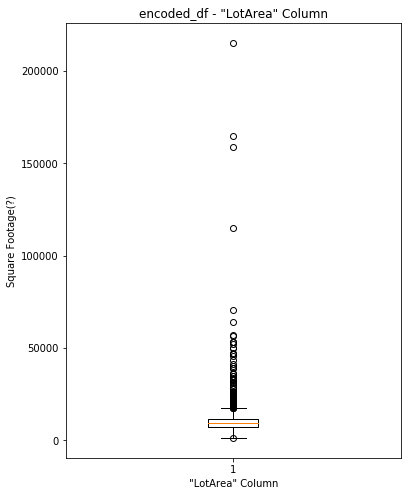

In [8]:
fig1, ax1 = plt.subplots(figsize=(6,8))
ax1.set_title('encoded_df - "LotArea" Column')
ax1.set_xlabel('"LotArea" Column')
ax1.set_ylabel('Square Footage(?)')
ax1.boxplot(encoded_df['LotArea'])
plt.show()

In [9]:
scaler = RobustScaler()

In [10]:
scale_columns = non_encode_columns[1:]
scaled_data = scaler.fit_transform(encoded_df[scale_columns])
scaled_df = pd.DataFrame(data=scaled_data, index = concat_df['Id'], columns=scale_columns)
encoded_df[scale_columns] = scaled_df[scale_columns].values

### Final Datames

In [11]:
train_df = encoded_df.xs(0)
train_df = train_df.set_index('Id')
test_df = encoded_df.xs(1)
test_df = test_df.set_index('Id')

In [12]:
train_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0.2,-0.239211,-0.245112,0.5,0.0,0.631579,0.256410,1.198777,0.459754,0.0,...,0,0,0,1,0,0,0,0,1,0
2,-0.6,0.594122,0.035924,0.0,3.0,0.063158,-0.435897,0.000000,0.830832,0.0,...,0,0,0,1,0,0,0,0,1,0
3,0.2,-0.072544,0.439150,0.5,0.0,0.589474,0.230769,0.990826,0.159618,0.0,...,0,0,0,1,0,0,0,0,1,0
4,0.4,-0.516989,0.023705,0.5,0.0,-1.221053,-0.589744,0.000000,-0.208731,0.0,...,0,0,0,1,1,0,0,0,0,0
5,0.2,0.816345,1.174731,1.0,0.0,0.568421,0.179487,2.140673,0.390177,0.0,...,0,0,0,1,0,0,0,0,1,0


# 1. Decision Tree

# 2. Random Forest

# 3. Support Vector Machines

# 4. K-Nearest Neighbors

# 5. Multilayer Perceptron

# SMOTE